In [2]:
%reload_ext autoreload
%autoreload 2

import datasets
import torch.nn as nn
import data_process as dp
import torchtext
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.utils

2023-03-03 22:34:35.445103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 22:34:36.570301: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-03 22:34:36.570361: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-03 22:34:36.570368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

#### Wzoruję się na publikacji [SentiMATE: Learning to play Chess through Natural Language Processing](./papers/SentiMate.pdf)

## Dane
Ruchy z komentarzami są wyciągnięte z gier z [gameknot.com](https://gameknot.com/list_annotated.pl?u=all), baza danych jest za duża na GitHuba, wrzuciłem ją na [dysk Google](https://drive.google.com/file/d/1JzrTIk67jJ4dd_Ak1y71mRd9rWuJij2f/view?usp=sharing)

* Ruchom z oznaczeniami `?` lub `??` na początku komentarza dałem `sentiment=0`. Ruchom z `!` lub `!!` - `sentiment=1`. Te komentarze mają `auto_sentiment=1`
* Do tego kilka komentarzy oceniłem ręcznie (pomijalna liczba).
* `sentiment=2` oznacza, że komentarz nie odnosi się do jakości ruchu, na tą chwilę oceniłem tak tylko kilka komentarzy. W tej publikacji mieli klasyfikator Quality/Non-quality, u mnie tego nie ma, przynajmniej na tę chwilę.


In [4]:
moves_df = datasets.load_sql_to_df("SELECT * FROM english_annotated_moves", "../chess.db")
moves_df

,index,position,move,comment,halfmove_number,game_id,sentiment,auto_sentiment
0,0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,This is my first gameknot game against someone...,1,44,2,0
1,1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,b1c3,"I've been playing the Vienna Gambit as white, ...",3,44,-1,0
2,2,rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQK...,f8c5,Minor disappointment.,4,44,-1,0
3,3,r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP4/PPP2PP...,f2f4,"My idea here is to expand on the kingside, dri...",9,44,-1,0
4,4,r1bqk2r/ppp2ppp/3p1n2/n1b1pP2/2B1P3/2NP4/PPP3P...,d1f3,"Maybe this isn't the greatest plan, since with...",13,44,0,0
...,...,...,...,...,...,...,...,...
326634,326634,rnb5/p2p1P1N/7p/1pR5/6P1/4k3/2P1B3/3Q1RK1 b - ...,b5b4,Pawn,86,70387,-1,0
326635,326635,rnb5/p2p1P1N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f7f8q,Check mate in two moves,87,70387,-1,0
326636,326636,rnb2Q2/p2p3N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 b -...,d7d6,Pawn,88,70387,-1,0
326637,326637,rnb2Q2/p6N/3p3p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f8e8,Check,89,70387,-1,0


## Preprocessing
Używam gotowych embeddingów, preprocessing wygląda tak:

1. Wzięcie komentarzy z `sentiment` = 0 lub 1
    * Dla każdego komentarza z oznaczeniem `?`/`??`/`!`/`!!`, została utworzona jego kopia z tym samym sentymentem, ale bez tego oznaczenia np. z komentarza `("! good move!", 1)` powstał drugi komentarz `("good move!", 1)`
2. Usunięcie z komentarzy notacji szachowej i części interpuncji
3. Podział na tokeny z użyciem [Spacy](https://spacy.io/)
4. Usunięcie tokenów, które nie mają embeddingów

Można to znaleźć w pliku [data_process.py](./data_process.py)

In [7]:
glove_embbedings = torchtext.vocab.GloVe(name="6B", dim=100, cache="../.vector_cache/")
datasets.add_padding_vector_to_embeddings(glove_embbedings)

In [ ]:
moves_df = dp.prepare_data_for_sentiment_analysis_training(moves_df, glove_embbedings.stoi)
moves_df

,comment,sentiment
0,"[maybe, this, be, not, the, great, plan, since...",0
1,"[?, too, slow, maybe, .]",0
2,"[?, this, allow, a, combination, by, white, .,...",0
3,"[!, !, brilliant, move, it, give, black, the, ...",1
4,"[!, !, this, move, be, really, fantastic, ., m...",1
...,...,...
19864,"[in, hindsight, be, need, to, get, my, king, t...",0
19865,"[keep, black, alive]",0
19866,"[time, remain, minute, .]",0
19867,"[black, be, win, .]",1


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Model
Warstwa `embedding` jest nietrenowana

In [6]:
def create_embedding_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer

class SentimentAnalysisLSTM(nn.Module):
    def __init__(self, embeddings: torchtext.vocab.Vectors, hidden_dim, num_layers = 2, dropout = 0.2):
        super().__init__()
        
        self.embedding = create_embedding_layer(embeddings.vectors, non_trainable=True)

        self.lstm = nn.LSTM(input_size=embeddings.dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)

        self.fc = nn.Linear(hidden_dim, 1)
        
        
    def forward(self, x):
        embedded = self.embedding(x)

        lstm_output, _ = self.lstm(embedded)
        last_lstm_output = lstm_output[:, -1, :]

        logits = self.fc(last_lstm_output)

        return logits


In [7]:
train_df, test_df = train_test_split(moves_df, test_size=0.05)
display(train_df)
display(test_df)

,comment,sentiment
15434,"[black, 's, ancient, weakness, at, be, suddenl...",1
9167,"[?, allow, to, ...]",0
15097,"[however, decide, to, mix, thing, up, straight...",0
13285,"[white, want, the, queen, to, escape, on, her,...",1
6117,"[!, of, course, be, also, playable, but, tell,...",1
...,...,...
15523,"[much, well, be, get, the, rook, off, of, the,...",0
4220,"[?, this, be, a, comment, by, the, page, take,...",0
995,"[!, this, bring, the, final, piece, into, play...",1
19045,"[so, try, something, else, as, my, plan, be, t...",0


,comment,sentiment
11072,"[white, have, the, chance, to, activate, his, ...",1
10145,"[white, keep, up, the, pressure, .]",1
15481,"[black, overlook, the, same, trick, that, whit...",0
13220,"[this, move, look, logical, try, to, stop, the...",0
13747,"[do, not, see, white, 's, strategy, behind, sa...",0
...,...,...
16357,"[black, want, to, lift, his, knight, to, a, ce...",0
13298,"[now, if, white, have, successfully, isolate, ...",0
18320,"[prevent, black, to, castle, and, allow, for, ...",0
2629,"[!, the, good, way, to, go, for, an, advantage...",1


In [8]:
train_dataset = datasets.PretrainedEmbeddingsIndicesDataset(train_df, glove_embbedings, random_state=1)
test_dataset = datasets.PretrainedEmbeddingsIndicesDataset(test_df, glove_embbedings, random_state=1)

### Długość komentarzy

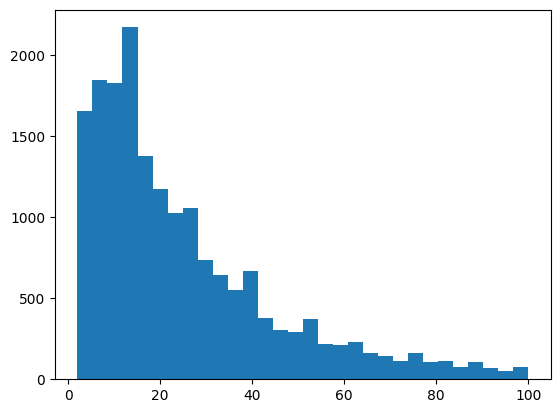

In [9]:
lengths = [len(x) for x,_ in train_dataset]
plt.hist(lengths, bins=30)
plt.show()

## Trenowanie modelu

In [10]:
def collate_batch(data):
    inputs = [item[0] for item in data]
    targets = [item[1] for item in data]

    input_batch = nn.utils.rnn.pad_sequence(inputs, batch_first=True)
    target_batch = torch.stack(targets)

    return input_batch, target_batch

In [11]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, collate_fn=collate_batch)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, collate_fn=collate_batch)

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer, num_epochs = 10, verbose = False):
    model.train()
    size = len(dataloader.dataset)
    loss_history = []

    for epoch in range(num_epochs):
        if verbose:
            print(f"epoch {epoch+1}/{num_epochs}")

        epoch_loss = 0

        for batch, (X, y) in enumerate(dataloader):
            # Compute prediction and loss
            X = X.to(device)
            y = y.to(device)
            out = model(X)
            loss = loss_fn(out, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * len(X)

            if batch % 100 == 0 and verbose:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        loss_history.append(epoch_loss/size)
        if verbose:
            print("--------------------------")

    return loss_history

In [13]:
model = SentimentAnalysisLSTM(embeddings=glove_embbedings, hidden_dim=128)
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
loss_history = train_loop(train_loader, model, criterion, optimizer, num_epochs=60, verbose=True)

epoch 1/60
loss: 0.270799  [   32/17914]
loss: 0.323209  [ 3232/17914]
loss: 0.192902  [ 6432/17914]
loss: 0.186232  [ 9632/17914]
loss: 0.290596  [12832/17914]
loss: 0.088423  [16032/17914]
--------------------------
epoch 2/60
loss: 0.246621  [   32/17914]
loss: 0.335614  [ 3232/17914]
loss: 0.194317  [ 6432/17914]
loss: 0.148604  [ 9632/17914]
loss: 0.268711  [12832/17914]
loss: 0.103127  [16032/17914]
--------------------------
epoch 3/60
loss: 0.242732  [   32/17914]
loss: 0.339398  [ 3232/17914]
loss: 0.172103  [ 6432/17914]
loss: 0.129916  [ 9632/17914]
loss: 0.243988  [12832/17914]


KeyboardInterrupt: 

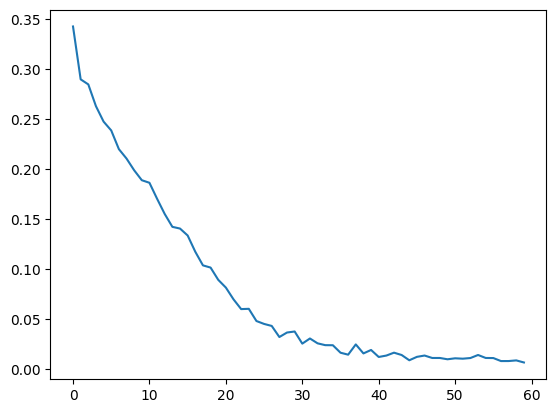

In [51]:
plt.plot(loss_history)
plt.show()

## Testowanie

In [144]:

def test_model(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()

    loss_fn = nn.BCEWithLogitsLoss(reduction='sum')

    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            out = model(X)
            test_loss += loss_fn(out, y).sum()

            pred = torch.round(torch.sigmoid(out))
            correct += (pred == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [145]:
test_model(test_loader, model)

RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR